In [21]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
from utils import score
import argparse
import pdb

In [22]:
import pandas as pd
import numpy as np 

def read_data_20m():
	print('reading movielens 20m data')
	ratings = pd.read_csv('../data/ml-25m/ratings.csv', engine='python')
	movies = pd.read_csv('../data/ml-25m/movies.csv', engine='python')
	links = pd.read_csv('../data/ml-25m/links.csv', engine='python')
	tags = pd.read_csv('../data/ml-25m/tags.csv', engine='python')
	movies = movies.join(movies.genres.str.get_dummies().astype(bool))
	movies.drop('genres', inplace=True, axis=1)
	logs = ratings.join(movies, on='movieId', how='left', rsuffix='_movie')
	return logs

def preprocess_movie_data_20m(logs, min_number_of_reviews=20000, balanced_classes=False):
	movies_to_keep = pd.DataFrame(logs.movieId.value_counts())\
		.loc[pd.DataFrame(logs.movieId.value_counts())['movieId']>=min_number_of_reviews].index
	logs = logs.loc[logs['movieId'].isin(movies_to_keep)]
	if balanced_classes is True:
		logs = logs.groupby('movieId')
		logs = logs.apply(lambda x: x.sample(logs.size().min()).reset_index(drop=True))
	logs = logs.sample(frac=1)
	logs['t'] = np.arange(len(logs)) ########## 't'는 학습 과정에서 time step을 나타냄
	logs.index = logs['t']
	logs['liked'] = logs['rating'].apply(lambda x: 1 if x >= 4.5 else 0) ####### 평점 4.5 이상을 like 처리 reward (1)
	return logs

def get_ratings_20m(min_number_of_reviews=20000, balanced_classes=False):
	logs = read_data_20m()
	logs = preprocess_movie_data_20m(logs, min_number_of_reviews=20000, balanced_classes=balanced_classes)
	return logs


In [23]:
def epsilon_greedy_policy(df, arms, epsilon=0.15, slate_size=5, batch_size=50):

    if np.random.uniform(0,1) < epsilon or df.shape[0]==0:
        return np.random.choice(arms, size=(slate_size), replace=False) ### random 선택
    
    else:
        scores = df[['movieId', 'liked']].groupby('movieId').agg({'liked': ['mean', 'count']})
        scores.columns = ['mean', 'count']
        scores['movieId'] = scores.index
        scores = scores.sort_values('mean', ascending=False) ################### 평균 높은 순으로 정렬
        recs = scores.loc[scores.index[0:slate_size], 'movieId'].values   ###### greedy 선택
    return recs

In [25]:
df = get_ratings_20m(min_number_of_reviews=1500, balanced_classes=True) ######## 데이터 불러오기


reading movielens 20m data
preparing ratings log


In [26]:
history = pd.DataFrame(data=None, columns=df.columns)
history = history.astype({'movieId': 'int32', 'liked': 'float'})

In [27]:
history.t

Series([], Name: t, dtype: object)

In [28]:
epsilon_rewards = [] ###### rewards 초기화
max_time = df.shape[0]

for t in range(max_time//10000): ### 학습
	t = t * 10000 ####### batch size 설정
	if t % 100000 == 0:
		print(t)
	recs = epsilon_greedy_policy(df=history.loc[history.t<=t,], arms=df.movieId.unique(), epsilon=0.02, slate_size=5, batch_size=10000)
	### time step 10000, 그 안에서 안겹치게 영화 정리-> arm
	history, action_score = score(history, df, t, 10000, recs)
	if action_score is not None:
		action_score = action_score.liked.tolist()
		epsilon_rewards.extend(action_score)

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000
2700000
2800000
2900000
3000000
3100000
3200000
3300000
3400000
3500000
3600000
3700000
3800000
3900000
4000000


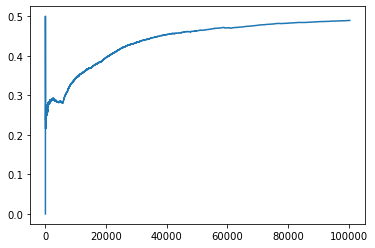

In [29]:
epsilon_greedy_cumulative_avg = np.cumsum(epsilon_rewards) / np.linspace(1, len(epsilon_rewards), len(epsilon_rewards)) ######### epsilon_reward 출력
plt.plot(epsilon_greedy_cumulative_avg, label='epsilon')

In [23]:
len(epsilon_rewards)

100296

In [30]:
def ucb1_policy(df, t): ######## ucb 알고리즘

	scores = df[['movieId', 'liked']].groupby('movieId').agg({'liked': ['mean', 'count', 'std']})
	scores.columns = ['mean', 'count', 'std']
	scores['ucb'] = scores['mean'] + np.sqrt(((2 * np.log10(t)) /scores['count']))
	scores['movieId'] = scores.index
	scores = scores.sort_values('ucb', ascending=False)
	recs = scores.loc[scores.index[0:5], 'movieId'].values
	return recs

In [31]:
b_history = df.groupby('movieId').first()
b_history['movieId'] = b_history.index
b_history['t'] = 0
b_history.index = b_history['t']
b_history['liked'] = 1
b_history = b_history[df.columns]
b_history2 = b_history.copy()
b_history2['liked'] = 0
b_history = pd.concat([b_history,b_history,b_history2,b_history2,b_history])
b_history['scoring_round'] = 0

In [32]:
ucb_rewards = [] ####### ucb 리워드 따로 설정
ucb_checkpoints = []
max_time = df.shape[0] 

In [33]:
for t in range(1, max_time//10000): #df.t:
	t = t * 10000
	if t % 100000 == 0:
		print(t)
	recs = ucb1_policy(df=b_history.loc[b_history.t<=t,], t = t/10000) 
	b_history, action_score = score(b_history, df, t, 10000, recs)
	if action_score is not None:
		action_score = action_score.liked.tolist()
		ucb_rewards.extend(action_score)

100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000
2700000
2800000
2900000
3000000
3100000
3200000
3300000
3400000
3500000
3600000
3700000
3800000
3900000
4000000


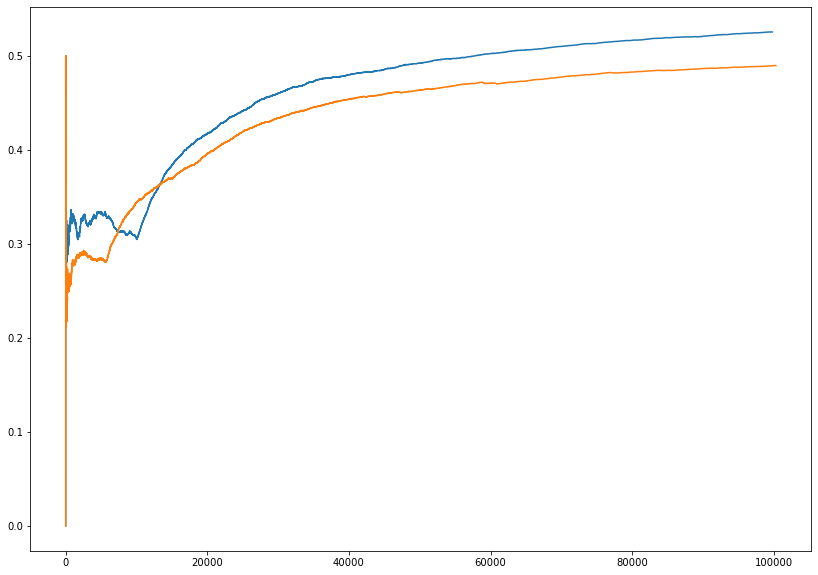

In [34]:
ucb_cumulative_avg = np.cumsum(ucb_rewards) / np.linspace(1, len(ucb_rewards), len(ucb_rewards))
plt.figure(figsize=(14,10))

plt.plot(ucb_cumulative_avg, label='epsilon')
plt.plot(epsilon_greedy_cumulative_avg, label='epsilon_greedy_cumulative_avg')



In [35]:
def softmax_exploration(df,arms, Temperature, slate_size=5):

	scores = df[['movieId', 'liked']].groupby('movieId').agg({'liked': ['mean', 'count', 'std']})
	scores.columns = ['mean', 'count', 'std']
	mean_list = scores['mean'].values.tolist()
	denom = sum(np.exp(mean_list[i]/Temperature) for i in range(len(arms)))
	probs = [np.exp(mean_list[i]/Temperature)/denom for i in range(len(arms))]
	recs = np.random.choice(arms, size=(slate_size), p=probs)

	return recs

In [36]:
c_history = df.groupby('movieId').first()
c_history['movieId'] = c_history.index
c_history['t'] = 0
c_history.index = c_history['t']
c_history['liked'] = 1
c_history = c_history[df.columns] 
c_history2 = c_history.copy()
c_history2['liked'] = 0
c_history = pd.concat([c_history,c_history,c_history2,c_history2,c_history])
c_history['scoring_round'] = 0

In [37]:
softmax_history = pd.DataFrame(data=None, columns = ['mean', 'count', 'std', 'ucb', 'movieId', 'iter']) 
softmax_rewards = []
softmax_checkpoints = []
max_time = df.shape[0]

In [38]:
for t in range(1, max_time//10000): #df.t:
	t = t * 10000
	if t % 100000 == 0:

		print(t)
	temp = 50
	recs = softmax_exploration(df=c_history.loc[c_history.t<=t,],arms=df.movieId.unique(),Temperature=temp,slate_size=5) 
	temp = temp * 0.5
	c_history, action_score = score(c_history, df, t, 10000, recs)
	if action_score is not None:
		action_score = action_score.liked.tolist()
		softmax_rewards.extend(action_score)

100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000
2700000
2800000
2900000
3000000
3100000
3200000
3300000
3400000
3500000
3600000
3700000
3800000
3900000
4000000


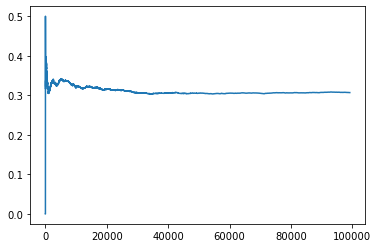

In [39]:
softmax_cumulative_avg = np.cumsum(softmax_rewards) / np.linspace(1, len(softmax_rewards), len(softmax_rewards))
plt.plot(softmax_cumulative_avg, label='epsilon')

In [ ]:

def Thomson_sampling(a,b,beta_val,df,slate_size=5):

	scores = df[['movieId', 'liked']].groupby('movieId').agg({'liked': ['mean', 'count', 'std']})
	scores.columns = ['mean', 'count', 'std']
	scores['movieId'] = scores.index

	for i in range(len(scores)):
		beta_val[i] = np.random.beta(a[i],b[i])
		scores['beta_val'] = beta_val[i]

	scores = scores.sort_values('beta_val', ascending=False)
	recs = scores.loc[scores.index[0:slate_size], 'movieId'].values

	return recs

In [ ]:
total_movie = len(df.movieId.unique())
a = np.ones(total_movie)
b = np.ones(total_movie)
 
for t in range(1, max_time//10000):
	t = t * 10000
	beta_val = np.ones(total_movie)
	if t % 100000 == 0:
		print(t)
	
	recs = Thomson_sampling(a,b,beta_val,df=c_history.loc[c_history.t<=t,],Temperature=temp,slate_size=5) 
	c_history, action_score = score(c_history, df, t, 10000, recs)
	if action_score is not None:
		action_score = action_score.liked.tolist()
		for i in range(len(action_score)):
			if action_score[i] == 1:
				a[i] +=1
			else:
				b[i] +=1
						
		softmax_rewards.extend(action_score)